First, the data is converted to csv format for easier use with pytorch.

In [2]:
import pandas as pd
import os
import sys

In [3]:
for file in list(os.listdir("data")):  # List so that writing to the directory doesn't affect the loop
	df = pd.read_csv(os.path.join("data", file), header=0, names=["sentence", "label"], delimiter="@", encoding="ISO-8859-1")
	df["numerical_label"] = df["label"].map({
		"negative": 0,
		"neutral": 1,
		"positive": 2
	})
	print(df.columns)
	df.to_csv(os.path.join("data", os.path.splitext(file)[0] + ".csv"))

# Visualising label bias #

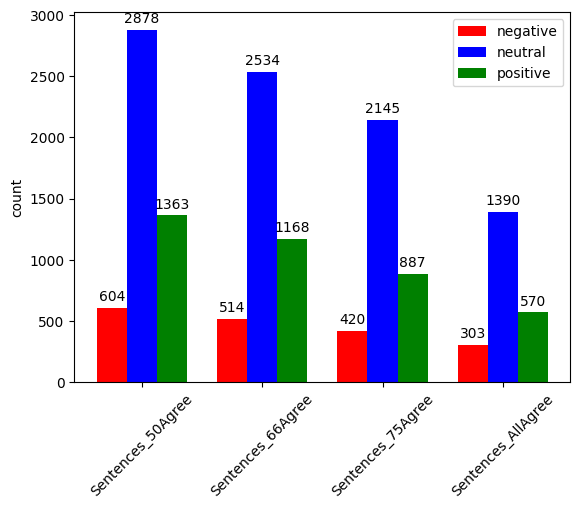

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.25

colors = ['red', 'blue', 'green']
files = []

for i, file in enumerate(os.listdir("data")):
	files.append(os.path.splitext(file)[0])
	df = pd.read_csv(os.path.join("data", file))
	for label, row in df.groupby("numerical_label").count().iterrows():
		offset = width * label
		bar = plt.bar(i + offset, row["sentence"], width, color=colors[label])
		plt.bar_label(bar, padding=3)

plt.ylabel("count")
plt.xticks(np.arange(len(os.listdir("data"))) + width, files, rotation=45)
plt.legend(["negative", "neutral", "positive"])

plt.figure().tight_layout()

As expected, more experts being required to agree results in both fewer training samples but also less bias in the data (particularly between positive and negative). Based on visual inspection, I've decided that 66Agree would be a good starting point to balance dataset size and label bias.

# Text Statistical Analysis #

Unfortonately, sentence length provides no real insights.

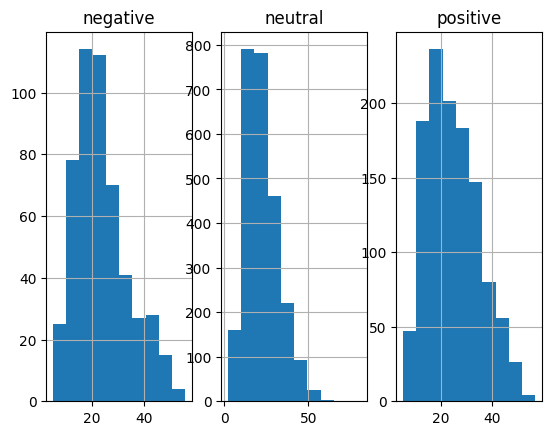

In [5]:
df = pd.read_csv(os.path.join("data", "sentences_66Agree.csv"))

fig, axes = plt.subplots(ncols=3)

for i, (label, group) in enumerate(df.groupby("label")):
	group["sentence"].str.split().map(len).hist(ax=axes[i])
	axes[i].title.set_text(label)

In [6]:
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

nltk.download("stopwords")
stop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taydo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


But the *content* of the sentences does tell us a lot. Compare the negative and positive plots below. Many key words appear more in one than the other (e.g. operating, quarter etc.) while others only appear in one (e.g. decreased, increased, loss etc.) all of this is good news when it comes to creating/analysing embedding spaces.

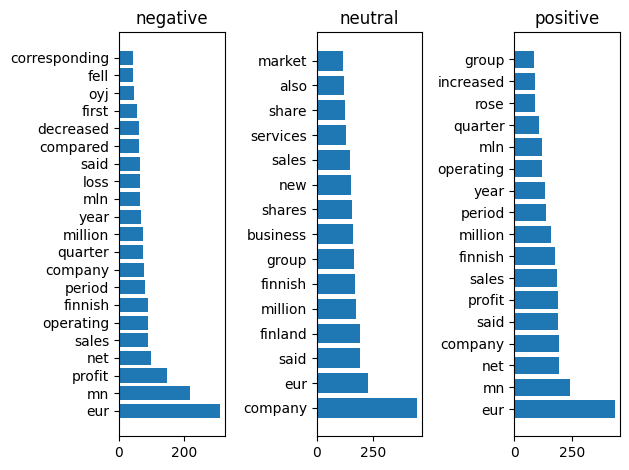

In [13]:
p = re.compile("[a-zA-Z ]")

fig, axes = plt.subplots(ncols=3)

corpus = {}

for i, (label, group) in enumerate(df.groupby("label")):
	corpus[label] = group["sentence"].str.lower().str.split().sum()
	corpus[label] = [s for s in corpus[label] if p.match(s)]
	most_common_words = Counter(corpus[label]).most_common()
	x = []
	y = []
	for word, count in most_common_words[:40]:
		if word not in stop:
			x.append(word)
			y.append(count)
	axes[i].barh(x, y)
	axes[i].title.set_text(label)

fig.tight_layout()

### N-grams ###

Displaying the top en 2-grams for each label, we see a similar encourage pattern to above. With only this cursorry look at the data we can already see examples (e.g. lay offs, co operations) of things which to a human convey clear sentiment.

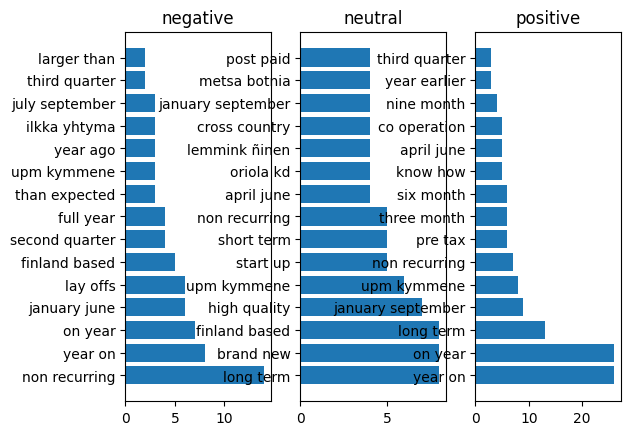

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axes = plt.subplots(ncols=3)

for i, label in enumerate(corpus):
	vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus[label])
	word_bag = vec.transform(corpus[label])
	word_sum = word_bag.sum(axis=0)
	freq = [(word, word_sum[0, idx]) for word, idx in vec.vocabulary_.items()]
	freq = sorted(freq, key=lambda x: x[1], reverse=True)[:15]
	x, y = map(list, zip(*freq))
	axes[i].barh(x, y)
	axes[i].title.set_text(label)


# Textblob sentiment analysis #

Interestingly, textblob's lexicon based sentiment analyser (no machine learning) peforms surprisingly well. Seen below, sentences with definite labels do skew more in the correct directions.

A potential problem presented in textblob's analysis is the skew in neutral labels towards positive sentiment. This may potentially represent a bias in the dataset towards positive terms that could trip up pre-trained models.

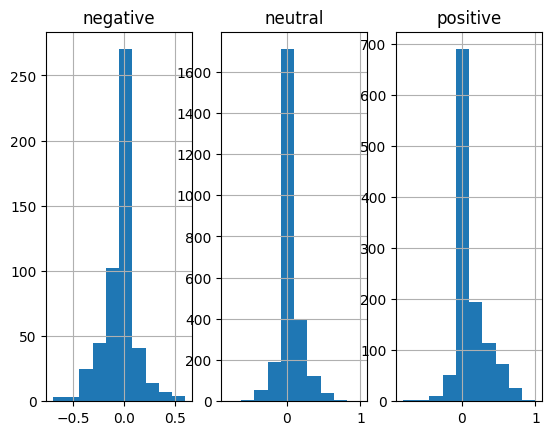

In [29]:
from textblob import TextBlob

fig, axes = plt.subplots(ncols=3)

for i, (label, group) in enumerate(df.groupby("label")):
	group["sentence"].apply(lambda s: TextBlob(s).sentiment.polarity).hist(ax=axes[i])
	axes[i].title.set_text(label)